## Holiday Package Prediciton

### 1) Problem statement.
"Trips & Travel.Com" company wants to enable and establish a viable business model to expand the customer base.
One of the ways to expand the customer base is to introduce a new offering of packages. Currently, there are 5 types of packages the company is offering * Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages. However, the marketing cost was quite high because customers were contacted at random without looking at the available information.
The company is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being.
However, this time company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient.
### 2) Data Collection.
The Dataset is collected from https://www.kaggle.com/datasets/susant4learning/holiday-package-purchase-prediction
The data consists of 20 column and 4888 rows.

In [31]:
!pip install xgboost

In [32]:
## importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [33]:
df = pd.read_csv("Travel.csv")
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


## Data Cleaning
### Handling Missing values
1. Handling Missing values
2. Handling Duplicates
3. Check data type
4. Understand the dataset

In [34]:
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [35]:
### Check all the categories 
df['Gender'].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [36]:
df['Gender'] = df['Gender'].str.replace('Fe Male','Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')

In [37]:
### Check all the categories 
df['Gender'].value_counts()

Gender
Male      2916
Female    1972
Name: count, dtype: int64

In [38]:
## Check Misssing Values
##these are the features with nan value

features_with_na = [features for features in df.columns if df[features].isnull().sum()>=1]
for features in features_with_na:
    print(features, np.round(df[features].isnull().mean()*100,5), '% missing values')
    print('\n')

Age 4.62357 % missing values


TypeofContact 0.51146 % missing values


DurationOfPitch 5.13502 % missing values


NumberOfFollowups 0.92062 % missing values


PreferredPropertyStar 0.53191 % missing values


NumberOfTrips 2.86416 % missing values


NumberOfChildrenVisiting 1.35025 % missing values


MonthlyIncome 4.76678 % missing values




In [39]:
## statistics on numerical columns

df[features_with_na].select_dtypes(exclude='object').describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


## Imputing Null values
1. Impute Median value for Age column
2. Impute Mode for Type of Contract
3. Impute Median for Duration of Pitch
4. Impute Mode for NumberofFollowup as it is Discrete feature
5. Impute Mode for PreferredPropertyStar
6. Impute Median for NumberofTrips
7. Impute Mode for NumberOfChildrenVisiting
8. Impute Median for MonthlyIncome

In [40]:
#Age
df.Age.fillna(df.Age.median(), inplace=True)

#TypeofContract
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True)

#DurationOfPitch
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True)

#NumberOfFollowups
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True)

#PreferredPropertyStar
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True)

#NumberOfTrips
df.NumberOfTrips.fillna(df.NumberOfTrips.median(), inplace=True)

#NumberOfChildrenVisiting
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0], inplace=True)

#MonthlyIncome
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True)

In [41]:
df.head()
df.isnull().sum()

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [42]:
df.drop('CustomerID', inplace=True, axis=1)

## Feature Engineering

### Feature Extraction

In [43]:
# create new column for feature
df['TotalVisiting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']
df.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)

In [44]:
## get all the numeric features
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 12


In [45]:
##categorical features
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 6


In [46]:
## Discrete features
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 9


In [47]:
## coontinuous features
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 3


## Train Test Split And Model Training

In [48]:
from sklearn.model_selection import train_test_split
X = df.drop(['ProdTaken'], axis=1)
y = df['ProdTaken']

In [49]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((3910, 17), (978, 17))

In [50]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

std_transformer = StandardScaler()
ohe_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    
    [
        ('StandardScaler',std_transformer,num_features),
        ('OHE',ohe_transformer,cat_features)
    ]
    
)

In [51]:
preprocessor


ColumnTransformer(transformers=[('StandardScaler', StandardScaler(),
                                 Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome', 'TotalVisiting'],
      dtype='object')),
                                ('OHE', OneHotEncoder(drop='first'),
                                 Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
       'MaritalStatus', 'Designation'],
      dtype='object'))])

In [52]:
## applying Trnsformation in training(fit_transform)
X_train=preprocessor.fit_transform(X_train)

In [53]:
X_train

array([[-0.15792615, -0.7214003 , -1.02034967, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50807196, -0.7214003 ,  0.69002334, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.39606944, -0.7214003 , -1.02034967, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.06407322,  1.45504659,  1.54520984, ...,  0.        ,
         0.        ,  0.        ],
       [-1.04592363,  1.45504659,  1.78954884, ...,  1.        ,
         0.        ,  0.        ],
       [-1.71192174, -0.7214003 , -0.77601067, ...,  0.        ,
         0.        ,  0.        ]], shape=(3910, 26))

In [54]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,-0.157926,-0.721400,-1.020350,1.284279,-0.725271,-0.127737,-0.632399,0.679690,0.782966,-0.382245,-0.774151,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.508072,-0.721400,0.690023,0.282777,-0.725271,1.511598,-0.632399,0.679690,0.782966,-0.459799,0.643615,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.396069,-0.721400,-1.020350,0.282777,1.771041,0.418708,-0.632399,0.679690,0.782966,-0.245196,-0.065268,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.064073,-0.721400,-1.020350,1.284279,-0.725271,-0.127737,-0.632399,1.408395,-1.277194,0.213475,-0.065268,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.730071,-0.721400,2.400396,-1.720227,-0.725271,1.511598,-0.632399,-0.049015,-1.277194,-0.024889,2.061382,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,-1.045924,-0.721400,-0.653841,1.284279,-0.725271,-0.674182,-0.632399,-1.506426,0.782966,-0.536973,0.643615,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3906,0.397072,1.455047,-0.898180,-0.718725,1.771041,-1.220627,-0.632399,1.408395,0.782966,1.529609,-0.065268,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3907,0.064073,1.455047,1.545210,0.282777,-0.725271,2.058043,-0.632399,-0.777720,0.782966,-0.360576,0.643615,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3908,-1.045924,1.455047,1.789549,1.284279,-0.725271,-0.127737,-0.632399,-1.506426,0.782966,-0.252799,0.643615,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [55]:
## apply tansformation on test(transform)
X_test=preprocessor.transform(X_test)

## Adaboost Classifier Training
#### We can also combine multiple algorithms


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 

In [57]:
models={
    "Logisitic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "Adaboost":AdaBoostClassifier(),
    "XgBoost": XGBClassifier()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

Logisitic Regression
Model performance for Training set
- Accuracy: 0.8460
- F1 score: 0.8202
- Precision: 0.7016
- Recall: 0.3032
- Roc Auc Score: 0.6368
----------------------------------
Model performance for Test set
- Accuracy: 0.8364
- F1 score: 0.8087
- Precision: 0.6914
- Recall: 0.2932
- Roc Auc Score: 0.6307


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9192
- F1 score: 0.9186
- Precision: 0.8043
- Recall: 0.7749
- Roc Auc Score: 0.8646


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9284
- F1 score: 0.9228
- Precision: 0.9690
- Recall: 0.6545
- Roc Auc Score: 0.8247


Gradient Boost
Model performance for Training se

In [75]:
## Hyperparameter Training
xgboost_param={"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

In [76]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("Xgboost", XGBClassifier(), xgboost_param)
                   
                   ]

In [77]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for Xgboost -------------------
{'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [78]:
input = "'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8"

input = input.replace(':',"=").replace("'","")
input

'n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 0.8'

In [79]:
models={
    
    "Random Forest":RandomForestClassifier(n_estimators=1000,min_samples_split=2,
                                          max_features=7,max_depth=None),
    "Xgboost": XGBClassifier(n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 0.8)
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9315
- F1 score: 0.9267
- Precision: 0.9627
- Recall: 0.6754
- Roc Auc Score: 0.8345


Xgboost
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9479
- F1 score: 0.9457
- Precision: 0.9545
- Recall: 0.7696
- Roc Auc Score: 0.8804




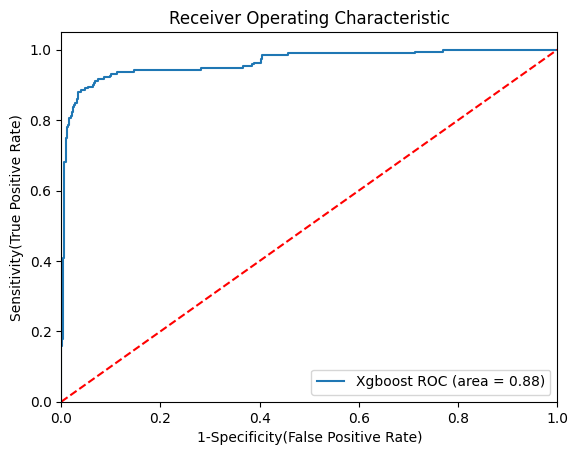

In [81]:
## Plot ROC AUC Curve
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Xgboost',
    'model': XGBClassifier(subsample = 0.6, reg_lambda = 1, reg_alpha = 0.1, n_estimators = 1000, min_child_weight = 1, max_depth = 20, learning_rate = 0.01, gamma = 0.1, colsample_bytree = 0.8),
    'auc': 0.8804
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("auc.png")
plt.show() 